In [2]:
# Необходимо получить три временные матрицы для трех режимов - "разгон", "подъем", "разгон-подъём"
# Для этого необходимо провести аппроксимации некоторых других функций, помимо тех, что мы получили в предыдущий раз
# Аппроксимацию будем проводить для высот в диапазоне от 700м до 8000м

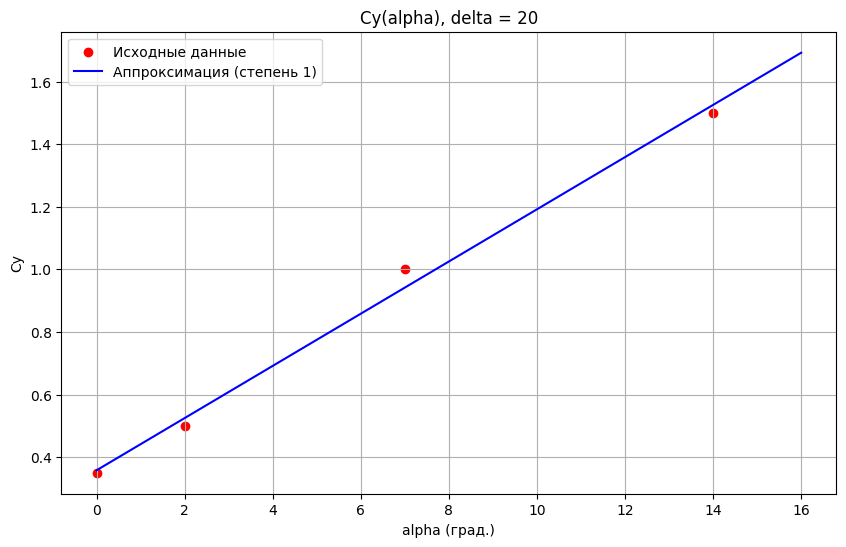

Получаем функцию: Сy(alpha) = 0.0834*alpha + 0.3579


In [3]:
# Воспользуюсь ранее реализованными функциями
import functions

import numpy as np

# Аппроксимация коэффециента подъёмной силы Cy от угла атаки alpha (возьму при delta = 20)

Cy = np.array([0.35, 0.5, 1, 1.5])
alpha = np.array([0, 2, 7, 14])

degree = 1  # Выбираем степень полинома

coeffs = functions.least_squares_fit(alpha, Cy, degree)

# Создание полинома на основе коэффициентов
poly = np.poly1d(coeffs)

# Генерация значений для аппроксимации
alpha_range = np.arange(0, 16 + 1, 1) # Интервал каждый градус
Cy_approximated = poly(alpha_range)

# Визуализация результатов
functions.plot_result(alpha, Cy, alpha_range, Cy_approximated, degree, 'alpha (град.)', 'Cy', 'Cy(alpha), delta = 20')

print(f'Получаем функцию: Сy(alpha) = {round(coeffs[0], 4)}*alpha + {round(coeffs[1], 4)}')

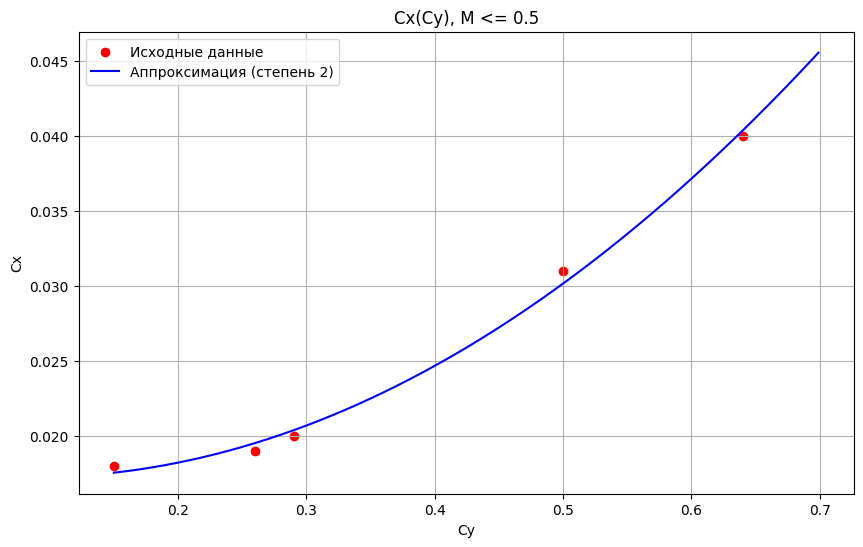

Получаем функцию: Сx(Cy) = 0.0752*Cy^2 + -0.0129*Cy + 0.0178


In [4]:
# Аппроксимация коэффециента лобового сопротивления Cx от коэффециента подъёмной силы Cy, который в свою очередь зависит от alpha

# Для M <= 0.5

Cx = np.array([0.018, 0.019, 0.02, 0.031, 0.04])
Cy = np.array([0.15, 0.26, 0.29, 0.5, 0.64])

degree = 2  # Выбираем степень полинома

coeffs = functions.least_squares_fit(Cy, Cx,  degree)

# Создание полинома на основе коэффициентов
poly = np.poly1d(coeffs)

# Генерация значений для аппроксимации
Cy_range = np.arange(0.15, 0.6 + 0.1, 0.001) 
Cx_approximated = poly(Cy_range)

# Визуализация результатов
functions.plot_result(Cy, Cx, Cy_range, Cx_approximated, degree, 'Cy', 'Cx', 'Cx(Cy), M <= 0.5')

print(f'Получаем функцию: Сx(Cy) = {round(coeffs[0], 4)}*Cy^2 + {round(coeffs[1], 4)}*Cy + {round(coeffs[2], 4)}')


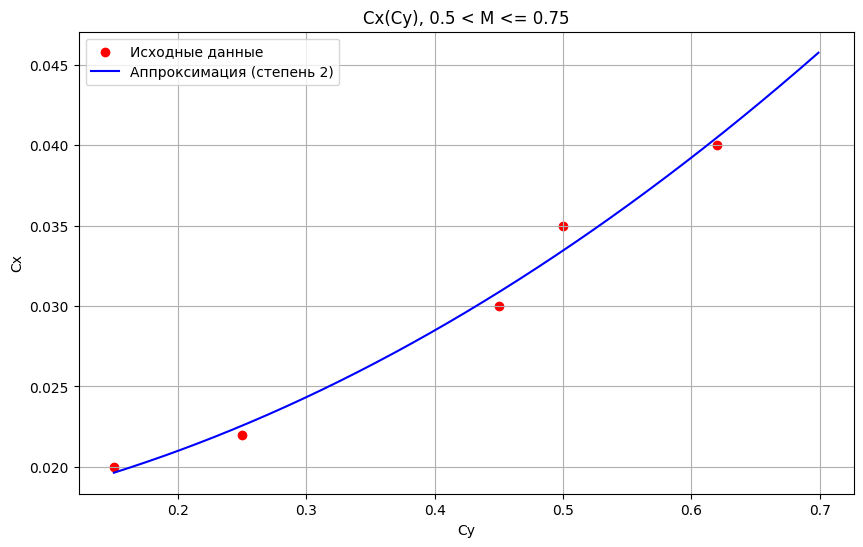

Получаем функцию: Сx(Cy) = 0.0407*Cy^2 + 0.013*Cy + 0.0168


In [5]:
# Аппроксимация коэффециента лобового сопротивления Cx от коэффециента подъёмной силы Cy, который в свою очередь зависит от alpha

# Для  0.5 < M <= 0.75

Cx = np.array([0.02, 0.022, 0.03, 0.035, 0.04])
Cy = np.array([0.15, 0.25, 0.45, 0.5, 0.62])

degree = 2  # Выбираем степень полинома

coeffs = functions.least_squares_fit(Cy, Cx,  degree)

# Создание полинома на основе коэффициентов
poly = np.poly1d(coeffs)

# Генерация значений для аппроксимации
Cy_range = np.arange(0.15, 0.6 + 0.1, 0.001) 
Cx_approximated = poly(Cy_range)

# Визуализация результатов
functions.plot_result(Cy, Cx, Cy_range, Cx_approximated, degree, 'Cy', 'Cx', 'Cx(Cy), 0.5 < M <= 0.75')

print(f'Получаем функцию: Сx(Cy) = {round(coeffs[0], 4)}*Cy^2 + {round(coeffs[1], 4)}*Cy + {round(coeffs[2], 4)}')


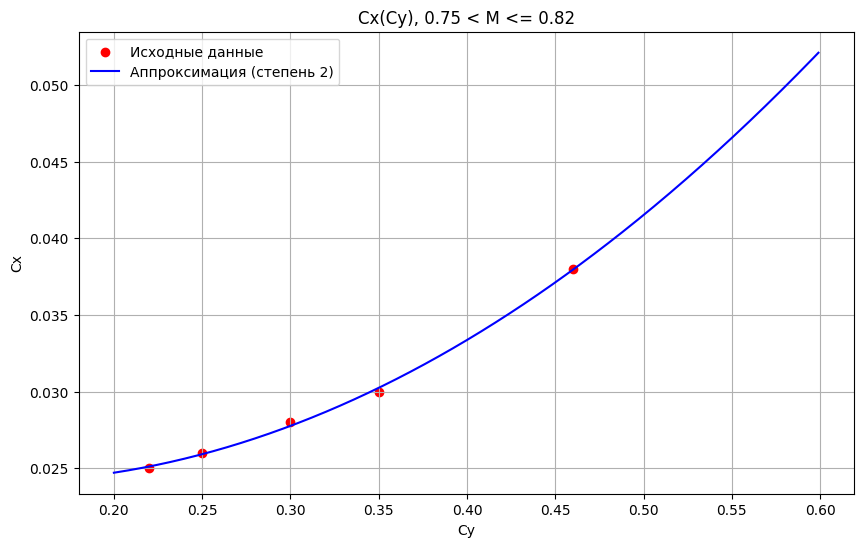

Получаем функцию: Сx(Cy) = 0.1275*Cy^2 + -0.0332*Cy + 0.0262


In [6]:
# Аппроксимация коэффециента лобового сопротивления Cx от коэффециента подъёмной силы Cy, который в свою очередь зависит от alpha

# Для  0.75 < M <= 0.82

Cx = np.array([0.025, 0.026, 0.028, 0.03, 0.038])
Cy = np.array([0.22, 0.25, 0.3, 0.35, 0.46])

degree = 2  # Выбираем степень полинома

coeffs = functions.least_squares_fit(Cy, Cx,  degree)

# Создание полинома на основе коэффициентов
poly = np.poly1d(coeffs)

# Генерация значений для аппроксимации
Cy_range = np.arange(0.2, 0.5 + 0.1, 0.001) 
Cx_approximated = poly(Cy_range)

# Визуализация результатов
functions.plot_result(Cy, Cx, Cy_range, Cx_approximated, degree, 'Cy', 'Cx', 'Cx(Cy), 0.75 < M <= 0.82')

print(f'Получаем функцию: Сx(Cy) = {round(coeffs[0], 4)}*Cy^2 + {round(coeffs[1], 4)}*Cy + {round(coeffs[2], 4)}')


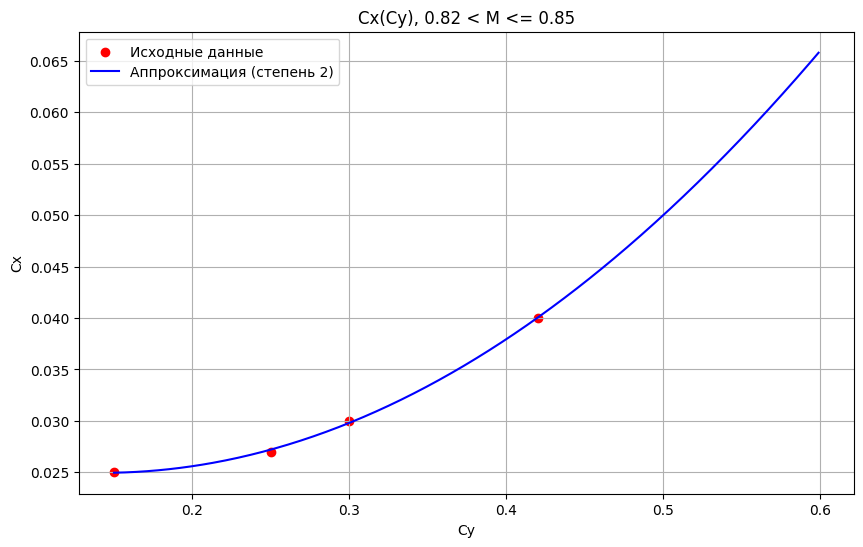

Получаем функцию: Сx(Cy) = 0.196*Cy^2 + -0.0559*Cy + 0.0289


In [7]:
# Аппроксимация коэффециента лобового сопротивления Cx от коэффециента подъёмной силы Cy, который в свою очередь зависит от alpha

# Для  0.82 < M <= 0.85

Cx = np.array([0.025, 0.027, 0.03, 0.04])
Cy = np.array([0.15, 0.25, 0.3, 0.42])

degree = 2  # Выбираем степень полинома

coeffs = functions.least_squares_fit(Cy, Cx,  degree)

# Создание полинома на основе коэффициентов
poly = np.poly1d(coeffs)

# Генерация значений для аппроксимации
Cy_range = np.arange(0.15, 0.5 + 0.1, 0.001) 
Cx_approximated = poly(Cy_range)

# Визуализация результатов
functions.plot_result(Cy, Cx, Cy_range, Cx_approximated, degree, 'Cy', 'Cx', 'Cx(Cy), 0.82 < M <= 0.85')

print(f'Получаем функцию: Сx(Cy) = {round(coeffs[0], 4)}*Cy^2 + {round(coeffs[1], 4)}*Cy + {round(coeffs[2], 4)}')

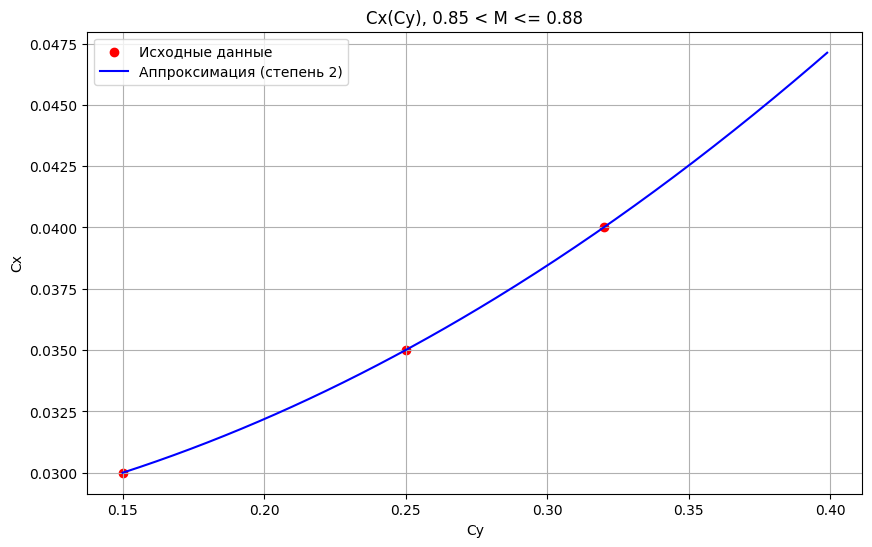

Получаем функцию: Сx(Cy) = 0.1261*Cy^2 + -0.0004*Cy + 0.0272


In [8]:
# Аппроксимация коэффециента лобового сопротивления Cx от коэффециента подъёмной силы Cy, который в свою очередь зависит от alpha

# Для  0.85 < M <= 0.88

Cx = np.array([0.03, 0.035, 0.04])
Cy = np.array([0.15, 0.25, 0.32])

degree = 2  # Выбираем степень полинома

coeffs = functions.least_squares_fit(Cy, Cx,  degree)

# Создание полинома на основе коэффициентов
poly = np.poly1d(coeffs)

# Генерация значений для аппроксимации
Cy_range = np.arange(0.15, 0.3 + 0.1, 0.001) 
Cx_approximated = poly(Cy_range)

# Визуализация результатов
functions.plot_result(Cy, Cx, Cy_range, Cx_approximated, degree, 'Cy', 'Cx', 'Cx(Cy), 0.85 < M <= 0.88')

print(f'Получаем функцию: Сx(Cy) = {round(coeffs[0], 4)}*Cy^2 + {round(coeffs[1], 4)}*Cy + {round(coeffs[2], 4)}')

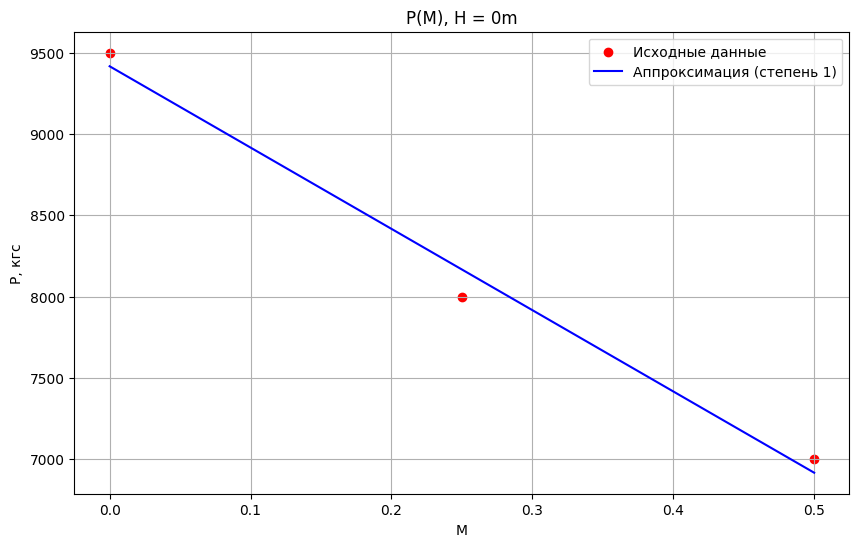

Получаем функцию: P(M) = -5000.0*M + 9417


In [9]:
# Аппроксимация тяги двигателя P от скорости полета M
# В результате получим зависимость тяги P от М, которая в свою очередь зависит от высоты полета 
# Для H = 0-4000m

P = np.array([9500, 8000, 7000])
M = np.array([0, 0.25, 0.5])

degree = 1  # Выбираем степень полинома

coeffs = functions.least_squares_fit(M, P,  degree)

# Создание полинома на основе коэффициентов
poly = np.poly1d(coeffs)

# Генерация значений для аппроксимации
M_range = np.arange(0, 0.6, 0.1)
P_approximated = poly(M_range)

# Визуализация результатов
functions.plot_result(M, P, M_range, P_approximated, degree, 'M', 'P, кгс', 'P(M), H = 0m')

print(f'Получаем функцию: P(M) = {round(coeffs[0], 2)}*M + {round(coeffs[1])}')

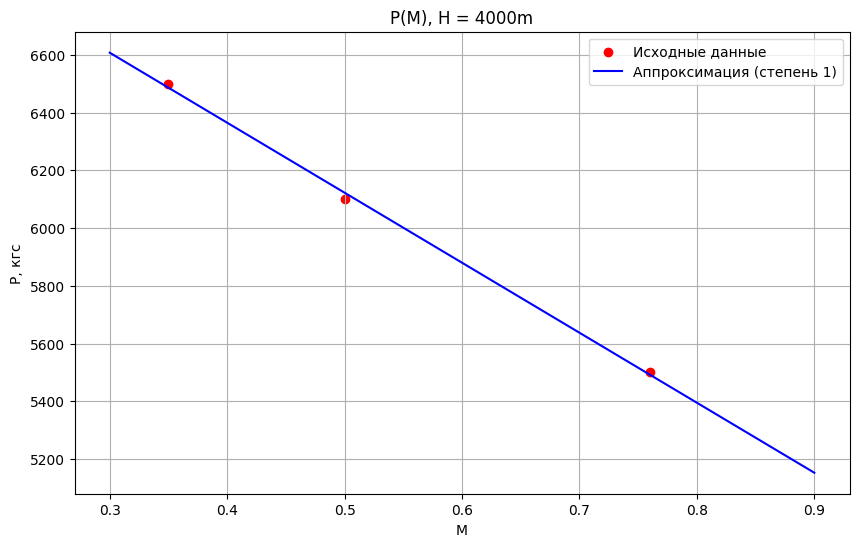

Получаем функцию: P(M) = -2424.48*M + 7334


In [10]:
# Для H = 4000-6000m

P = np.array([6500, 6100, 5500])
M = np.array([0.35, 0.5, 0.76])

degree = 1  # Выбираем степень полинома

coeffs = functions.least_squares_fit(M, P,  degree)

# Создание полинома на основе коэффициентов
poly = np.poly1d(coeffs)

# Генерация значений для аппроксимации
M_range = np.arange(0.3, 0.9, 0.1)
P_approximated = poly(M_range)

# Визуализация результатов
functions.plot_result(M, P, M_range, P_approximated, degree, 'M', 'P, кгс', 'P(M), H = 4000m')

print(f'Получаем функцию: P(M) = {round(coeffs[0], 2)}*M + {round(coeffs[1])}')

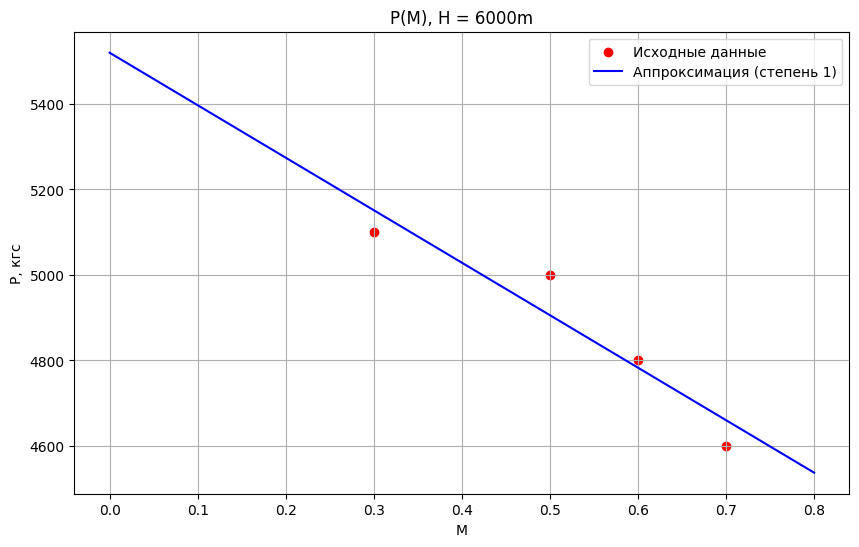

Получаем функцию: P(M) = -1228.57*M + 5520


In [11]:
# Для H = 6000-8000m

P = np.array([5100, 5000, 4800, 4600])
M = np.array([0.3, 0.5, 0.6, 0.7])

degree = 1  # Выбираем степень полинома

coeffs = functions.least_squares_fit(M, P,  degree)

# Создание полинома на основе коэффициентов
poly = np.poly1d(coeffs)

# Генерация значений для аппроксимации
M_range = np.arange(0, 0.9, 0.1) # Интервал каждый градус
P_approximated = poly(M_range)

# Визуализация результатов
functions.plot_result(M, P, M_range, P_approximated, degree, 'M', 'P, кгс', 'P(M), H = 6000m')

print(f'Получаем функцию: P(M) = {round(coeffs[0], 2)}*M + {round(coeffs[1])}')

In [12]:
# Теперь мы располагаем всеми необходимыми зависимостями
# Реализация функций расчета времени в разных режимах

import math
from math import cos, log

import approximated


def razgon(H, V1, V2, mass, S, phi=0):
    """
    Режим разгон
    :param H: высота полета = const
    :param V1: начальная скорость
    :param V2: конечная скорость
    :param mass: масса ЛА
    :param S: приведенная площадь
    :param phi: угол наклона двигателя
    :return: время для режима "разгон"
    """
    V = (V1 + V2) / 2

    ro = approximated.ro(H)
    g = approximated.g(H)
    speed_of_sound = approximated.sound_speed(H)
    M = V / speed_of_sound
    P = approximated.P_h(M, H)
    # Сy(alpha) = 0.0834*alpha + 0.3579
    Cya = 0.0834
    Cy0 = 0.3579
    alpha = (mass * g - (P * phi / 57.3) - Cy0 * ro * V ** 2 * S / 2) / (P / 57.3 + Cya * ro * V ** 2 * S / 2)
    alpha_radians = math.radians(alpha)

    Cy = approximated.Cy(alpha)
    Cx = approximated.Cx(Cy, M)
    ans = abs((mass * (V2 - V1)) / (P * cos(alpha_radians + phi) - Cx * ro * V ** 2 * S / 2))
    return ans if ans > 0 else 1000


def pod(H1, H2, V, mass, S, phi=0):
    """
    Режим подъём
    :param H1: начальная высота полета
    :param H2: конечная высота полета
    :param V: скорость ЛА = const
    :param mass: масса ЛА
    :param S: приведенная площадь
    :param phi: угол наклона двигателя
    :return: время для режима "подъём"
    """
    H = (H1 + H2) / 2

    ro = approximated.ro(H)
    g = approximated.g(H)
    speed_of_sound = approximated.sound_speed(H)
    M = V / speed_of_sound
    P = approximated.P_h(M, H)
    # Сy(alpha) = 0.0834*alpha + 0.3579
    Cya = 0.0834
    Cy0 = 0.3579
    alpha = (mass * g - (P * phi / 57.3) - Cy0 * ro * V ** 2 * S/ 2) / (P / 57.3 + Cya * ro * V ** 2 * S / 2)

    Cy = approximated.Cy(alpha)
    Cx = approximated.Cx(Cy, M)
    X = Cx * ro * V ** 2 * S / 2
    teta = ((P - X) * 57.3) / (mass * g)
    ans = abs((57.3 * (H2 - H1)) / (V * teta))
    return ans if ans > 0 else 1000


def raz_pod(H1, H2, V1, V2, mass, S, phi=0):
    """
    Режим разгон-подъём
    :param H1: начальная высота полёта
    :param H2: конечаня высота полёта
    :param V1: начальная скорость ЛА
    :param V2: конечная скорость ЛА
    :param mass: масса ЛА
    :param S: приведенная площадь
    :param phi: угол наклона двигателя
    :return: время для режима "разгон-подъём"
    """
    V = (V1 + V2) / 2
    H = (H1 + H2) / 2

    ro = approximated.ro(H)
    g = approximated.g(H)
    speed_of_sound = approximated.sound_speed(H)
    M = V / speed_of_sound
    P = approximated.P_h(M, H)
    # Сy(alpha) = 0.0834*alpha + 0.3579
    Cya = 0.0834
    Cy0 = 0.3579
    alpha = (mass * g - (P * phi / 57.3) - Cy0 * ro * V ** 2 * S / 2) / (P / 57.3 + Cya * ro * V ** 2 * S / 2)
    alpha_radians = math.radians(alpha)

    Cy = approximated.Cy(alpha)
    Cx = approximated.Cx(Cy, M)

    k = (V2 - V1) / (H2 - H1)
    X = Cx * ro * V ** 2 * S / 2
    sin_teta = (P * cos(alpha_radians + phi) - X) / (mass * (k * V + g))
    return abs(1 / (k * sin_teta) * log(V2 / V1))

In [13]:
import pandas as pd

# Параметры ЛА
mass = 47000 # кг
S = 127 # м^2
phi = 0

n = 10
Vn = 350 * 1000 / 3600  # из км/ч в м/с
Vk = 880 * 1000 / 3600

V1n = 350
V1k = 880

Hn = 500
Hk = 8000
deltaV = (Vk - Vn) / n  # приращение скорости
deltaH = (Hk - Hn) / n  # приращение высоты
deltaV1 = (V1k - V1n) / n


# Создаем временные матрицы Tr, Tp, Trp с избежанием отрицательных значений
Tr = np.empty((n + 1, n), dtype=object)  # Матрица Tr
Tp = np.empty((n, n + 1), dtype=object)  # Матрица Tp
Trp = np.empty((n, n), dtype=object)  # Матрица Trp

# Заполняем матрицу Tr
for i in range(n + 1):
    Hi = Hn + i * deltaH
    for j in range(n):
        Vi = Vn + j * deltaV
        Traz = razgon(Hi, Vi, Vi + deltaV, mass, S, phi)
        Tr[i, j] = Traz

# Заполняем матрицу Tp
for i in range(n):
    Hi = Hn + i * deltaH
    for j in range(n + 1):
        Vi = Vn + j * deltaV
        Tpod = pod(Hi, Hi + deltaH, Vi, mass, S, phi)
        Tp[i, j] = Tpod

# Заполняем матрицу Trp
for i in range(n):
    Hi = Hn + i * deltaH
    for j in range(n):
        Vi = Vn + j * deltaV
        Traz_pod = raz_pod(Hi, Hi + deltaH, Vi, Vi + deltaV, mass, S, phi)
        Trp[i, j] = Traz_pod


# Create row and column labels
row_labels_Tr = [f"H={Hn + i * deltaH}" for i in range(n + 1)]
column_labels_Tr = [f"V={round(Vn + j * deltaV)}" for j in range(n)]

row_labels_Tp = [f"H={Hn + i * deltaH}" for i in range(n)]
column_labels_Tp = [f"V={round(Vn + j * deltaV)}" for j in range(n + 1)]

row_labels_Trp = [f"H={Hn + i * deltaH}" for i in range(n)]
column_labels_Trp = [f"V={round(Vn + j * deltaV)}" for j in range(n)]

# Create DataFrames with labels
df_Tr = pd.DataFrame(Tr, index=row_labels_Tr, columns=column_labels_Tr)
df_Tp = pd.DataFrame(Tp, index=row_labels_Tp, columns=column_labels_Tp)
df_Trp = pd.DataFrame(Trp, index=row_labels_Trp, columns=column_labels_Trp)

# Print DataFrames with labels
print("Матрица Tr:")
print(df_Tr)
print("\nМатрица Tp:")
print(df_Tp)
print("\nМатрица Trp:")
print(df_Trp)

Матрица Tr:
               V=97      V=112      V=127      V=141      V=156      V=171  \
H=500.0   13.037218  13.587578   14.77254  16.743989   19.95722   33.65731   
H=1250.0  13.177593   13.57353  14.582068  16.291299  19.033115  30.261427   
H=2000.0  13.371306  13.608461  14.451422  15.931865  18.288604  27.697119   
H=2750.0   13.62564  13.695266  14.379427  15.656872  17.693722  25.715944   
H=3500.0  13.949725   13.83787  14.366061  15.460048   19.94416  24.162181   
H=4250.0  19.632378  18.417738  18.437975  19.300598   24.90733  29.659475   
H=5000.0  20.539149  18.841795  18.564849  19.158544  23.969874  27.896878   
H=5750.0  21.682151  19.395436  18.793963  19.124734   23.23542  26.527192   
H=6500.0  45.536726  34.010186  30.485899  29.862696   37.94957  44.727431   
H=7250.0  53.069459  36.502493   31.57277  30.211259  36.675183  42.093609   
H=8000.0  64.504097  39.732311   32.98508  30.797076  35.774422  40.167944   

              V=186       V=200        V=215       

In [14]:
flight_types = {
    1: 'Разгон',
    2: 'Подъём',
    3: 'Разгон-подъём'
}

V1n = 350
V1k = 880
deltaV1 = (V1k - V1n) / n

Way = np.zeros((n + 1, n + 1, 2))

# Заолняем "очевидные" значения
for i in range(n - 1, -1, -1):
    Way[i, n] = [Way[i + 1, n, 0] + Tp[i, n], 2]

for j in range(n - 1, -1, -1):
    Way[n, j] = [Way[n, j + 1, 0] + Tr[n, j], 1]
    
row_labels_Way = [f"H={Hn + i * deltaH}" for i in range(n + 1)]
column_labels_Way = [f"V={round(V1n + j * deltaV1)}" for j in range(n + 1)]

df_Way = pd.DataFrame(Way[:, :, 0], index=row_labels_Way, columns=column_labels_Way)
print(df_Way)

               V=350       V=403       V=456       V=509       V=562  \
H=500.0     0.000000    0.000000    0.000000    0.000000    0.000000   
H=1250.0    0.000000    0.000000    0.000000    0.000000    0.000000   
H=2000.0    0.000000    0.000000    0.000000    0.000000    0.000000   
H=2750.0    0.000000    0.000000    0.000000    0.000000    0.000000   
H=3500.0    0.000000    0.000000    0.000000    0.000000    0.000000   
H=4250.0    0.000000    0.000000    0.000000    0.000000    0.000000   
H=5000.0    0.000000    0.000000    0.000000    0.000000    0.000000   
H=5750.0    0.000000    0.000000    0.000000    0.000000    0.000000   
H=6500.0    0.000000    0.000000    0.000000    0.000000    0.000000   
H=7250.0    0.000000    0.000000    0.000000    0.000000    0.000000   
H=8000.0  694.947932  630.443836  590.711525  557.726445  526.929369   

               V=615       V=668       V=721       V=774       V=827  \
H=500.0     0.000000    0.000000    0.000000    0.000000    0.0

In [15]:
for i in range(9, -1, -1):
    for j in range(9, -1, -1):
        Way[i, j] = [Way[i, j + 1, 0] + Tr[i, j], 1]
        if Trp[i, j] + Way[i + 1, j + 1, 0] < Way[i, j, 0]:
            Way[i, j] = [Trp[i, j] + Way[i + 1, j + 1, 0], 3]
        elif Tp[i, j] + Way[i + 1, j, 0] < Way[i, j, 0]:
            Way[i, j] = [Tp[i, j] + Way[i + 1, j, 0], 2]


df_Way = pd.DataFrame(Way[:, :, 0], index=row_labels_Way, columns=column_labels_Way)
print(df_Way)

df_Way = pd.DataFrame(Way[:, :, 1], index=row_labels_Way, columns=column_labels_Way)
print(df_Way)

total_time_res = Way[0, 0, 0]

                V=350        V=403        V=456        V=509        V=562  \
H=500.0   1233.921620  1247.904502  1341.195158  1530.796706  1642.286750   
H=1250.0  1161.406466  1158.129668  1177.413463  1271.789882  1458.813989   
H=2000.0  1098.039073  1084.667766  1087.599379  1108.779516  1201.585214   
H=2750.0  1035.465729  1021.840089  1013.837143  1019.457037  1039.966472   
H=3500.0   978.218120   964.268396   950.430526   945.909582   951.681943   
H=4250.0   935.138439   915.506061   897.088323   882.438704   878.841692   
H=5000.0   867.640797   847.101649   828.259853   809.695004   798.711334   
H=5750.0   805.359802   783.677651   764.282215   745.488252   726.363519   
H=6500.0   878.458246   832.921520   798.911335   768.425436   757.943218   
H=7250.0   780.764034   727.694575   691.192082   659.619312   637.749771   
H=8000.0   694.947932   630.443836   590.711525   557.726445   526.929369   

                V=615        V=668        V=721        V=774        V=827  

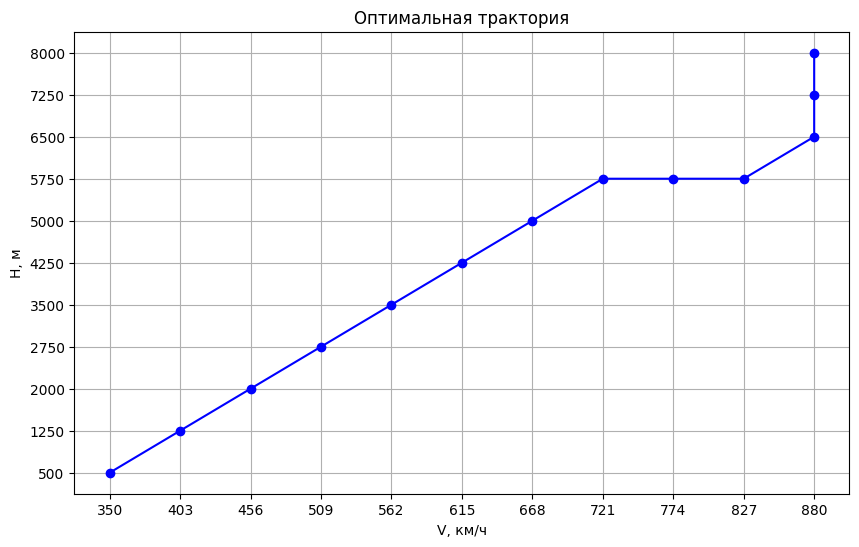

Время полета: 1233.9216200529404 секунд


In [16]:
import pylab
from pylab import *

i = 0
j = 0
k = 0
V = np.zeros(n * 2 + 1)
H = np.zeros(n * 2 + 1)

V[k] = V1n
H[k] = Hn
k += 1

while Way[i, j, 1] != 0:
    if Way[i, j, 1] == 1:
        j += 1
        V[k] = V[k - 1] + deltaV1
        H[k] = H[k - 1]
    elif Way[i, j, 1] == 2:
        i += 1
        H[k] = H[k - 1] + deltaH
        V[k] = V[k - 1]
    elif Way[i, j, 1] == 3:
        j += 1
        i += 1
        H[k] = H[k - 1] + deltaH
        V[k] = V[k - 1] + deltaV1

    k += 1

while np.any(V[-1] == 0):
    V = V[:-1]
    H = H[:-1]


plt.figure(figsize=(10, 6))
pylab.xticks(np.unique(V))
pylab.yticks(np.unique(H))
plt.plot(V, H, marker='o', linestyle='-', color='b')
plt.xlabel('V, км/ч')
plt.ylabel('H, м')
plt.title('Оптимальная трактория')
plt.grid(True)
plt.show()

print(f"Время полета: {total_time_res} секунд")
